Reference: https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Personal Notes
- https://docs.pytorch.org/docs/stable/tensorboard.html
- https://docs.pytorch.org/vision/main/models/convnext.html
- https://github.com/pytorch/vision/blob/main/torchvision/models/convnext.py

In [1]:
import os
import sys

import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
import time
from torch.utils.tensorboard import SummaryWriter

# set seed to make notebook reproducable
np.random.seed(42)
torch.cuda.manual_seed_all(42)
torch.manual_seed(42)
generator = torch.Generator().manual_seed(42)
path = 'results/'
best_model_path = os.path.join(path, 'best_model.pt')

I0000 00:00:1763335598.621451   23091 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1763335598.651310   23091 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Hyperparameters

In [2]:
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 8e-4
DROPOUT = 0.5

##### Load Data
Using this dataset: https://www.kaggle.com/datasets/echometerhhwl/pokemon-gen-1-38914

Other datasets we found:
- https://www.kaggle.com/datasets/thedagger/pokemon-generation-one
- https://www.kaggle.com/datasets/lantian773030/pokemonclassification
- https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset
- https://www.kaggle.com/datasets/adamstanley537/pokemon-gen-1-image-dataset-27000-images

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

# https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/3
class PokemonDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

# Data augmentations
data_transforms = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [4]:
data = torchvision.datasets.ImageFolder(root='data/pokemon')
train_set, val_set, test_set = torch.utils.data.random_split(data, [0.7, 0.15, 0.15], generator)

train_set = PokemonDataset(train_set, transform=data_transforms)
val_set = PokemonDataset(val_set, transform=data_transforms)
test_set = PokemonDataset(test_set, transform=test_transforms)

image_datasets = {
    'train': train_set,
    'val': val_set,
    'test': test_set
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=16)
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = data.classes

##### Training Code

In [5]:
def train(model, muon_opt, adamw_opt, criterion):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in dataloaders['train']:
        images, labels = images.to('cuda'), labels.to('cuda')

        # zero the parameter gradients for both optimizers
        muon_opt.zero_grad()
        adamw_opt.zero_grad()

        # forward
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward
        loss.backward()

        # optimizer steps
        muon_opt.step()
        adamw_opt.step()

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    return epoch_loss, epoch_acc

def validate(model, criterion, option):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():  # no gradient tracking
        for images, labels in dataloaders[option]:
            images, labels = images.to('cuda'), labels.to('cuda')

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[option]
    epoch_acc = running_corrects.double() / dataset_sizes[option]
    return epoch_loss, epoch_acc

In [6]:
# reference: https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, muon_opt, adamw_opt, criterion, muon_sched, adamw_sched, num_epochs=NUM_EPOCHS):
    time_start = time.time()
    best_acc = 0.0
    writer = SummaryWriter()
    print('Training started...\n')

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        
        train_loss, train_acc = train(model, muon_opt, adamw_opt, criterion)
        val_loss, val_acc = validate(model, criterion, 'val')

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print('-' * 10)
        print()

        # log data with tensorboard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        # step schedulers
        if muon_sched is not None:
            muon_sched.step()
        if adamw_sched is not None:
            adamw_sched.step()

        # save best model
        if val_acc > best_acc:
            best_acc = val_acc
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'class_names': class_names,
                'muon_opt_state': muon_opt.state_dict(),
                'adamw_opt_state': adamw_opt.state_dict()
            }
            torch.save(checkpoint, best_model_path)
    
    time_elapsed = time.time() - time_start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    writer.close()

##### Create Model

In [7]:
from torchvision.models import convnext_base, ConvNeXt_Base_Weights

model = convnext_base(weights=ConvNeXt_Base_Weights.DEFAULT)
# model.classifer[2] is the linear layer
num_feats = model.classifier[2].in_features
model.classifier[2] = torch.nn.Sequential(
    torch.nn.Dropout(DROPOUT),
    torch.nn.Linear(num_feats, len(class_names))
)
model = model.to('cuda')

##### Start Training

In [8]:
import warnings
warnings.filterwarnings('ignore', message="Palette images with Transparency expressed in bytes")

In [9]:
# collect parameter groups
head_keywords = ['classifier', 'head', 'head_classifier']
muon_params = []
adam_params = []

for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    # treat as head param if name contains any head keyword
    if any(k in name for k in head_keywords):
        adam_params.append(p)
    else:
        # Muon only supports 2D weight matrices, use adam for rest
        if p.dim() == 2:
            muon_params.append(p)
        else:
            adam_params.append(p)

print(f"Muon params: {len(muon_params)}, AdamW params: {len(adam_params)}")

# create optimizers
muon_lr = 1e-3
adamw_lr = 7.5e-4

muon_opt = torch.optim.Muon(muon_params, lr=muon_lr)
adamw_opt = torch.optim.AdamW(adam_params, lr=adamw_lr)

muon_sched = torch.optim.lr_scheduler.CosineAnnealingLR(muon_opt, T_max=NUM_EPOCHS)
adamw_sched = torch.optim.lr_scheduler.CosineAnnealingLR(adamw_opt, T_max=NUM_EPOCHS)

criterion = torch.nn.CrossEntropyLoss()
train_model(model, muon_opt, adamw_opt, criterion, muon_sched, adamw_sched, NUM_EPOCHS)

Muon params: 72, AdamW params: 272
Training started...



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/9
Train Loss: 1.6327 | Train Acc: 0.6504
Val Loss: 0.5630 | Val Acc: 0.8675
----------

Train Loss: 1.6327 | Train Acc: 0.6504
Val Loss: 0.5630 | Val Acc: 0.8675
----------

Epoch 1/9
Epoch 1/9
Train Loss: 0.6105 | Train Acc: 0.8522
Val Loss: 0.4907 | Val Acc: 0.8829
----------

Train Loss: 0.6105 | Train Acc: 0.8522
Val Loss: 0.4907 | Val Acc: 0.8829
----------

Epoch 2/9
Epoch 2/9
Train Loss: 0.5010 | Train Acc: 0.8732
Val Loss: 0.4580 | Val Acc: 0.8877
----------

Train Loss: 0.5010 | Train Acc: 0.8732
Val Loss: 0.4580 | Val Acc: 0.8877
----------

Epoch 3/9
Epoch 3/9
Train Loss: 0.4236 | Train Acc: 0.8933
Val Loss: 0.4396 | Val Acc: 0.8918
----------

Train Loss: 0.4236 | Train Acc: 0.8933
Val Loss: 0.4396 | Val Acc: 0.8918
----------

Epoch 4/9
Epoch 4/9
Train Loss: 0.3792 | Train Acc: 0.9056
Val Loss: 0.3817 | Val Acc: 0.9092
----------

Train Loss: 0.3792 | Train Acc: 0.9056
Val Loss: 0.3817 | Val Acc: 0.9092
----------

Epoch 5/9
Epoch 5/9
Train Loss: 0.3399 | Train Acc

##### Load Model

In [10]:
model.load_state_dict(torch.load(best_model_path, weights_only=True)["model_state_dict"])
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

##### Accuracy on Test Set

In [11]:
criterion = torch.nn.CrossEntropyLoss()
test_loss, test_acc = validate(model, criterion, 'test')
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.3200 | Test Acc: 0.9242


Overall accuracy: 0.9242

Per-class precision / recall / f1:
000 Abra                      P=0.952 R=0.952 F1=0.952
001 Aerodactyl                P=0.900 R=0.964 F1=0.931
002 Alakazam                  P=0.879 R=0.853 F1=0.866
003 Arbok                     P=0.958 R=0.979 F1=0.968
004 Arcanine                  P=0.903 R=0.966 F1=0.933
005 Articuno                  P=0.972 R=0.972 F1=0.972
006 Beedrill                  P=1.000 R=0.960 F1=0.980
007 Bellsprout                P=0.927 R=1.000 F1=0.962
008 Blastoise                 P=0.897 R=0.946 F1=0.921
009 Bulbasaur                 P=0.881 R=0.922 F1=0.901
010 Butterfree                P=0.971 R=1.000 F1=0.986
011 Caterpie                  P=0.964 R=0.964 F1=0.964
012 Chansey                   P=0.951 R=0.929 F1=0.940
013 Charizard                 P=0.969 R=0.912 F1=0.939
014 Charmander                P=0.937 R=0.881 F1=0.908
015 Charmeleon                P=0.871 R=0.931 F1=0.900
016 Clefable                  P=0.968 R=0.857 F1=0.909
017 

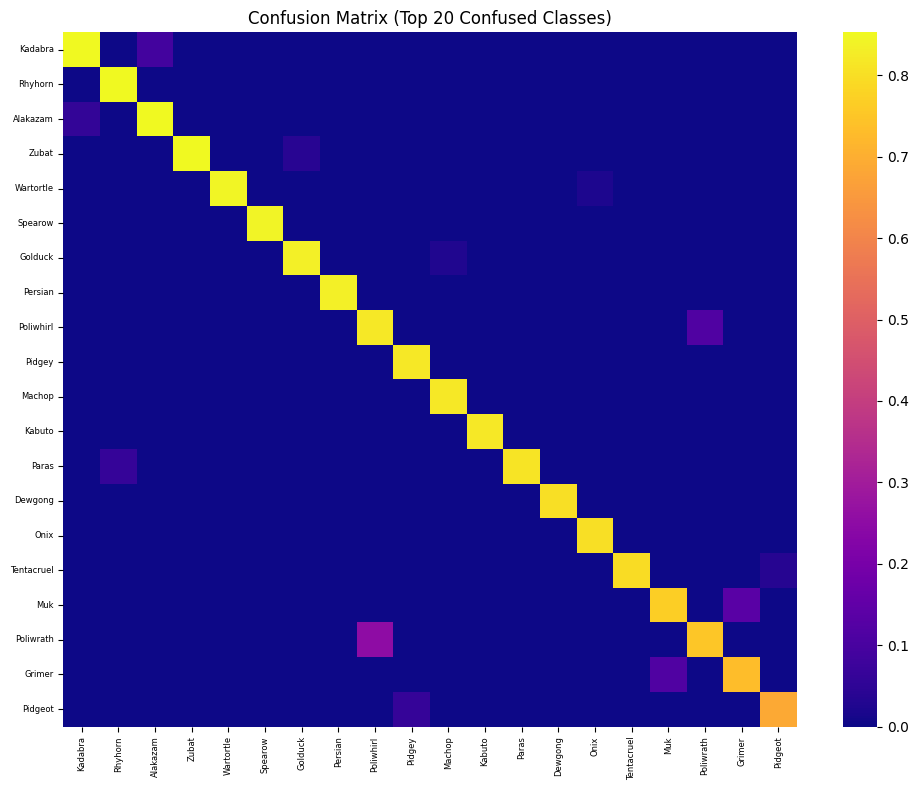

In [19]:
# Confusion matrix + precision/recall on the test set
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

# Collect predictions and labels
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in dataloaders['test']:
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
print(f"Overall accuracy: {(all_preds == all_labels).mean():.4f}")
print('\nPer-class precision / recall / f1:')
for i, name in enumerate(class_names):
    print(f"{i:03d} {name:25s} P={precision[i]:.3f} R={recall[i]:.3f} F1={f1[i]:.3f}")

print('\nClassification report:')
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Plot the worst results with confusion matrix
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
K = 20  # number of classes to display (choose whatever you want)

# Choose classes with the worst recall (most confused)
errors = 1 - np.diag(cm_norm)  # 1 - recall
top_k_idx = np.argsort(errors)[-K:]   # K worst ones

cm_small = cm_norm[top_k_idx][:, top_k_idx]
names_small = [class_names[i] for i in top_k_idx]

# --- seaborn plot ---
plt.figure(figsize=(10, 8))
seaborn.heatmap(
    cm_small,
    annot=False,
    cmap="plasma",
    xticklabels=names_small,
    yticklabels=names_small,
    cbar=True
)

plt.title(f'Confusion Matrix (Top {K} Confused Classes)')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()